In [1]:
import glob
import os
import numpy as np
from collections import Counter
import copy

from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy.sparse import csr_matrix, vstack, find

In [2]:
class Traitement:
    def __init__(self, lowerCaps=True, stopWords=True, stemm=True):
        self.stopwords_list = set(stopwords.words('english'))
        self.stopWords = stopWords
        self.lowerCaps = lowerCaps
        self.stemm = stemm
        if self.lowerCaps==False and self.stemm==True:
            print("Warning: lowerCaps is mandatory with Stemmatization, lowerCaps=False will have no effect")
    
    def tokenize(self, text):
        stemmer = SnowballStemmer('english')
        tokens = word_tokenize(text)
        stems = [stemmer.stem(item) for item in tokens]
        return " ".join(stems)
    
    def removeStopWords(self, text):
        words = word_tokenize(text)
        wordsFiltered = []
        for w in words:
            if w not in self.stopwords_list:
                wordsFiltered.append(w)
        return " ".join(wordsFiltered)
    
    def processing(self, corpus):
        texts = copy.deepcopy(corpus)
        for i in range(len(texts)):
            #lower caps
            if self.lowerCaps:
                texts[i] = texts[i].lower()
            #removing stop words
            if self.stopWords:
                texts[i] = self.removeStopWords(texts[i])
            #stemming
            if self.stemm:
                texts[i] = self.tokenize(texts[i])
        return texts

In [3]:
#IMPORTATION DES ENSEMBLES D'APPRENTISSAGE
path_neg = 'AFDmovies/movies1000/neg/'
X_neg = []
for filename in glob.glob(os.path.join(path_neg, '*.txt')):
    with open(filename, 'r') as f: # open in readonly mode
        X_neg.append(f.read())

path_pos = 'AFDmovies/movies1000/pos/'
X_pos = []
for filename in glob.glob(os.path.join(path_pos, '*.txt')):
    with open(filename, 'r') as f: # open in readonly mode
        X_pos.append(f.read())

In [4]:
#CREATION DE L'ENSEMBLE DE TEST
X_test = []
file_test = 'moviesTest/testSentiment.txt'
with open(file_test, 'r', encoding='utf-8') as f: # open in readonly mode
    txt = f.readline()
    while txt:
        X_test.append(txt)
        txt = f.readline()

In [5]:
X_train = np.array(X_neg+X_pos)
Y_train = np.array([-1]*len(X_neg)+[1]*len(X_pos))

## Apprentissage supervisé

In [107]:
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='sigmoid', gamma=1, C=10, coef0=0.1)),
])
pipeline.fit(X_train,Y_train)
print(np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=5, scoring='f1')))

0.86033411716753


In [106]:
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(\
        penalty='elasticnet', alpha=0.0001, l1_ratio=0.25,\
        learning_rate='constant', eta0=0.1, n_jobs=5)),
])
pipeline.fit(X_train,Y_train)
print(np.mean(cross_val_score(\
        pipeline, X_train, Y_train, cv=10, n_jobs=5, scoring='f1')))

0.8677175505619005


plotX = ['MultinomialNB', 'SGD', 'LogisticRegression', 'DecisionTree', 'KNeighbors(k=3)']
plotY=[[],[],[]]

pipeline1 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
pipeline1.fit(X_train,Y_train)

plotY[0].append(np.mean(cross_val_score(pipeline1, X_train, Y_train, cv=5)))
plotY[1].append(np.mean(cross_val_score(pipeline1, X_train, Y_train, cv=5, scoring='f1')))
plotY[2].append(np.mean(cross_val_score(pipeline1, X_train, Y_train, cv=5, scoring='roc_auc')))

pipeline2 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])
pipeline2.fit(X_train,Y_train)

plotY[0].append(np.mean(cross_val_score(pipeline2, X_train, Y_train, cv=5)))
plotY[1].append(np.mean(cross_val_score(pipeline2, X_train, Y_train, cv=5, scoring='f1')))
plotY[2].append(np.mean(cross_val_score(pipeline2, X_train, Y_train, cv=5, scoring='roc_auc')))

pipeline3 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])
pipeline3.fit(X_train, Y_train)

plotY[0].append(np.mean(cross_val_score(pipeline3, X_train, Y_train, cv=5)))
plotY[1].append(np.mean(cross_val_score(pipeline3, X_train, Y_train, cv=5, scoring='f1')))
plotY[2].append(np.mean(cross_val_score(pipeline3, X_train, Y_train, cv=5, scoring='roc_auc')))

pipeline4 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier()),
])
pipeline4.fit(X_train, Y_train)

plotY[0].append(np.mean(cross_val_score(pipeline4, X_train, Y_train, cv=5)))
plotY[1].append(np.mean(cross_val_score(pipeline4, X_train, Y_train, cv=5, scoring='f1')))
plotY[2].append(np.mean(cross_val_score(pipeline4, X_train, Y_train, cv=5, scoring='roc_auc')))

pipeline5 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(3)),
])
pipeline5.fit(X_train, Y_train)

plotY[0].append(np.mean(cross_val_score(pipeline5, X_train, Y_train, cv=5)))
plotY[1].append(np.mean(cross_val_score(pipeline5, X_train, Y_train, cv=5, scoring='f1')))
plotY[2].append(np.mean(cross_val_score(pipeline5, X_train, Y_train, cv=5, scoring='roc_auc')))

import numpy as np
import matplotlib.pyplot as plt
Xindices = np.arange(len(plotX))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rect1 = ax.bar(Xindices, plotY[0], width, label='accuracy')
rect2 = ax.bar(Xindices+width, plotY[1], width, label='f1')
rect3 = ax.bar(Xindices+2*width, plotY[2], width, label='roc_auc')

ax.set_ylabel('scores')
ax.set_title('Scores par classifieur (n-grams: 1 + 2)')
ax.set_xticks(Xindices+width)
ax.set_xticklabels(plotX)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
fig.tight_layout()
plt.show()

## Apprentissage non-supervisé

In [6]:
from sklearn.cluster import KMeans

In [7]:
pipelineKMean = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', KMeans(n_clusters=2)),
])
pipelineKMean.fit(X_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=2, n_init=10, n_jobs=None,

In [8]:
#sur 2000 exemples, si c'est proche de 1000 alors les clusters sont equilibrés
np.sum(pipelineKMean['clf'].labels_)

964

In [9]:
# Toute cette boite ne sert qu'à recuperer les termes dominants des clusters dans des ensembles
km = pipelineKMean['clf']
centroid1 = km.cluster_centers_[0]
centroid2 = km.cluster_centers_[1]

vectorizer = pipelineKMean['vect']
words = vectorizer.get_feature_names()

words1 = []
for val,word in zip(centroid1,words):
    words1.append((float(val),word))

words2 = []
for val,word in zip(centroid2,words):
    words2.append((float(val),word))
    
def sortFirst(val): 
    return val[0]

words1.sort(key = sortFirst, reverse=True)
words11 = np.array(words1)
set1 = set(words11[:75][:,1])

words2.sort(key = sortFirst, reverse=True)
words22 = np.array(words2)
set2 = set(words22[:75][:,1])

In [29]:
neg_words = ' '.join(X_neg)
pos_words = ' '.join(X_pos)

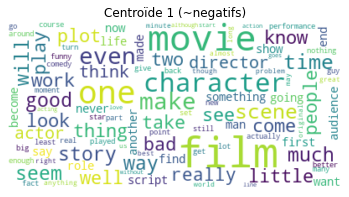

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")
wordcloud.generate(neg_words)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Centroïde 1 (~negatifs)")
plt.show()

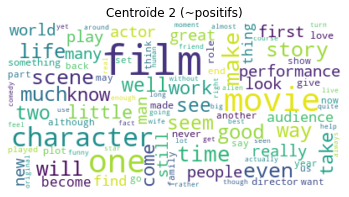

In [32]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")
wordcloud.generate(pos_words)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Centroïde 2 (~positifs)")
plt.show()